In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data sources: 
# Air Quality: https://www.arpalombardia.it/Pages/Aria/Richiesta-Dati.aspx
# Covid data : https://github.com/pcm-dpc/COVID-19

# Air quality processing
AQ = pd.read_csv("RW_20200411155304_56884_10320_1.csv",skiprows=3)
AQ.rename(columns={"Data/Ora": "data", " PM10  - µg/m³": "PM10"},inplace=True)
AQ["PM10"].replace(to_replace=-999, value=np.nan,inplace = True)
AQ["data"] = pd.to_datetime(AQ["data"],format="%Y/%m/%d").dt.strftime('%d %b')
AQ.set_index("data",inplace=True)

# Download Covid-19 data divided by district
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv";
covid = pd.read_csv(url)
covid = covid[covid["denominazione_provincia"] == "Milano"][["data","totale_casi"]].reset_index()
covid["data"] = pd.to_datetime(covid['data']).dt.strftime('%d %b')
covid = covid.drop(columns="index").set_index("data")

# create a time dataframe
times =pd.DataFrame(index = pd.date_range(start='1/1/2020',end='4/10/2020').strftime('%d %b'))

# combine datasets
data = times.merge(AQ,how='left',left_index=True, right_index=True)
data = data.merge(covid,how='left',left_index=True, right_index=True)

# add Covid new cases
data["daily_cases"] = data["totale_casi"].diff()

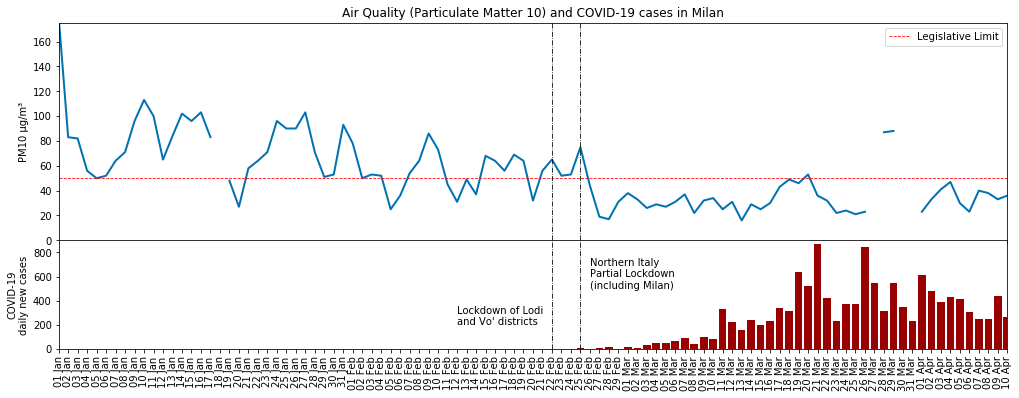

In [2]:
import matplotlib.gridspec as gridspec
plt.style.use('seaborn-colorblind')

fig = plt.figure(figsize = (17,6))
gspec = gridspec.GridSpec(3,1)
gspec.update(hspace=0) # set the spacing between axes.
axs = list('12')
axs[0] = plt.subplot(gspec[:2,0])
axs[1] = plt.subplot(gspec[2:,0])

axs[0].plot(data.index, data["PM10"],linewidth=2)
axs[0].plot([data.index[0],data.index[-1]],[50,50],'--',color="red",label="Legislative Limit",linewidth=0.8)
axs[1].bar(data.index,data["daily_cases"],color = "#990000")

# print lockdowns
notes = ["Lockdown of Lodi\nand Vo' districts", "Northern Italy\nPartial Lockdown\n(including Milan)"]
for n in range(2):
    axs[n].plot([data.index[52],data.index[52]],[0,axs[n].get_ylim()[1]],'-.',color="black",linewidth=0.8)
    axs[n].plot([data.index[55],data.index[55]],[0,axs[n].get_ylim()[1]],'-.',color="black",linewidth=0.8)

axs[1].text(data.index[42],200,notes[0])
axs[1].text(data.index[56],500,notes[1])

axs[0].set_xlim(data.index[0],data.index[-1])
axs[1].set_xlim(data.index[0],data.index[-1])
axs[0].set_ylim(0,175)
axs[1].set_ylim(0,900)
axs[0].set_xticklabels([])

axs[0].legend()
axs[0].set_title('Air Quality (Particulate Matter 10) and COVID-19 cases in Milan')
axs[0].set_ylabel('PM10 µg/m³')
axs[1].set_ylabel('COVID-19\ndaily new cases')

plt.xticks(rotation=90);

plt.savefig("AirQuality_Covid-19.png",dpi=150)
